In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
import gc
import matplotlib.pyplot as plt

In [5]:
time_data = pd.read_csv('data/original/time_data.txt', sep  = ' ') 
time_data = df2npy(time_data)

# 아침 점심 저녁 분리
morning_data = time_data[:,2,:,:]

# tend, cycle 추출
#morning_data = append_trend_cycle(morning_data)
morning_data, train_valid_test_loc_index, m_time_scaler = split_train_valid_test(morning_data)
nontime_data = pd.read_csv('data/original/nontime_data.txt', sep = ' ')

# no time data
notime, no_time_scaler = split_notime_data(nontime_data, train_valid_test_loc_index)

# train, valid, test
m_train_time, m_train_notime, m_train_y = make_time_notime_data(morning_data[0], notime)
m_valid_time, m_valid_notime, m_valid_y = make_time_notime_data(morning_data[1], notime)
m_test_time, m_test_notime, m_test_y = make_time_notime_data(morning_data[2], notime)

Exception: Data must be 1-dimensional

In [11]:
# set constant
LOC_SIZE = 69
TIME_SIZE = 3
DATE_SIZE = 241
FEATURE_SIZE = 13
#set window size
INPUT_WINDOW = 20
OUTPUT_WINDOW = 7
ROLLSIZE = 7



# flow_tot -> flow_trend + flow_cycle 분리
def split_trend_cycle(flow_pop):
    new_flow_pop = np.zeros([LOC_SIZE, flow_pop.shape[1] - (ROLLSIZE-1), 2])

    for loc in range(LOC_SIZE):
        new_flow_pop[loc,:, 0] = seq2cycle(flow_pop[loc,:])[ROLLSIZE-1:]
        new_flow_pop[loc,:, 1] = flow_pop[loc, ROLLSIZE-1:] - new_flow_pop[loc,:, 0]
    #print(new_flow_pop)
    return new_flow_pop


def df2npy(time_data):
    # make loc_list(dong code)
    loc_list = list(time_data.HDONG_CD.unique())

    # select features
    time_data = time_data[['flow_pop', 'HDONG_CD', 'time',
                        'card_use', 'holiday', 'day_corona', 'ondo', 'subdo',
                        'rain_snow', 'STD_YMD']]

    # change string time to int time
    time_data.time[time_data.time == 'morning'] = 0 # morning
    time_data.time[time_data.time == 'lunch'] = 1 # lunch
    time_data.time[time_data.time == 'evening'] = 2 # evening

    # to datetime
    time_data.STD_YMD = pd.to_datetime(time_data.STD_YMD)

    # make dayofyear weekday
    time_data['dayofyear'] = time_data.STD_YMD.dt.dayofyear
    time_data['weekday'] = time_data.STD_YMD.dt.weekday
    time_data['dayofyear_sin'] = np.sin(2 * np.pi * (time_data['dayofyear'])/365)
    time_data['dayofyear_cos'] = np.cos(2 * np.pi * (time_data['dayofyear'])/365)
    time_data['weekday_sin'] = np.sin(2 * np.pi * (time_data['weekday'])/7)# 월화수목금토일
    time_data['weekday_cos'] = np.cos(2 * np.pi * (time_data['weekday'])/7)

    # reselect features
    time_data = time_data[['HDONG_CD', 'time','flow_pop',
                        'card_use', 'holiday', 'day_corona', 'ondo', 'subdo',
                        'rain_snow', 'dayofyear_sin', 'dayofyear_cos', 'weekday_sin', 'weekday_cos']]

    # table -> matrix
    time_data = np.array(time_data).reshape(LOC_SIZE, TIME_SIZE, DATE_SIZE, FEATURE_SIZE)# 지역, 시간, 날짜, features
    return time_data


class StandardScalerSelect(StandardScaler):
    def __init__(self, copy=True, with_mean=True, with_std=True):
        self.shape = None
        super().__init__(copy, with_mean, with_std)
    def fit(self, X):
        self.shape = X.shape
        super().fit(X)

    def inverse_transform(self, X, select_col = None):
        if select_col != None:
            temp_X = np.zeros([X.shape[0], self.shape[1]])
            temp_X[:,select_col] = X
            trans = super().inverse_transform(temp_X)
            return trans[:,select_col]
        else:
            trans = super().inverse_transform(X)
            return trans

    def transform(self, X, select_col = None):
        if select_col != None:
            temp_X = np.zeros([X.shape[0], self.shape[1]])
            temp_X[:,select_col] = X
            trans = super().transform(temp_X)
            return trans[:,select_col]
        else:
            trans = super().transform(X)
            return trans

def scaleing_time(data, scaler = None):
    shape = data.shape
    #print(shape)
    data = data.reshape(-1, shape[-1])
    if scaler == None:
        scaler = StandardScalerSelect()
        scaler.fit(data)
    scaled_data = scaler.transform(data)
    return scaler, scaled_data.reshape(shape)


def scaleing_no_time(data, scaler = None):
    df_index = data.index
    df_columns = data.columns
    data = data.values
    if scaler == None:
        scaler = StandardScalerSelect()
        scaler.fit(data)
    data = scaler.transform(data)
    data = pd.DataFrame(data, index = df_index, columns = df_columns)
    return scaler, data

def split_train_valid_test(time_data):
    # make_random 
    loc_index = [i for i in range(69)]
    random.seed(1015)
    random.shuffle(loc_index)

    # split time data
    train_time = time_data[loc_index[ :55], :201, :]
    valid_time_1 = time_data[loc_index[ :55], 201 -INPUT_WINDOW : -20, :] # train 지역& valid 기간
    valid_time_2 = time_data[loc_index[55:62], : -20, :] # valid 지역 & (train + valid) 기간
    test_time_1 = time_data[loc_index[:62], 221 -INPUT_WINDOW : , :] # train,valid 지역& test 기간
    test_time_2 = time_data[loc_index[62:], :, :] # test 지역 & (train + valid + test) 기간

    # set loc index
    train_loc_index = list(set(train_time[:,0,0].astype(np.int64)))
    valid_loc_index = list(set(valid_time_2[:,0,0].astype(np.int64)))
    test_loc_index = list(set(test_time_2[:,0,0].astype(np.int64)))

    #scaling - time # 지역별 스케일링
    time_scaler, train_time[:,:,2:] = scaleing_time(train_time[:,:,2:])
    _, valid_time_1[:,:,2:] = scaleing_time(valid_time_1[:,:,2:], time_scaler)
    _, valid_time_2[:,:,2:] = scaleing_time(valid_time_2[:,:,2:], time_scaler)
    _, test_time_1[:,:,2:] = scaleing_time(test_time_1[:,:,2:], time_scaler)
    _, test_time_2[:,:,2:] = scaleing_time(test_time_2[:,:,2:], time_scaler)

    train_valid_test = [train_time, valid_time_1, valid_time_2, test_time_1, test_time_2]
    train_valid_test_index = [train_loc_index, valid_loc_index, test_loc_index]

    return train_valid_test, train_valid_test_index, time_scaler

def split_notime_data(nontime_data, train_valid_test_index):
    train_loc_index, valid_loc_index, test_loc_index= train_valid_test_index
    # make no time data
    nontime_data = nontime_data[['HDONG_CD', 'time', 'tot_pop', 'age_80U', 'AREA']]
    nontime_data = nontime_data.groupby(['HDONG_CD']).sum()

    # split no time data
    train_no_time = nontime_data.loc[train_loc_index]
    valid_no_time = nontime_data.loc[valid_loc_index]
    test_no_time = nontime_data.loc[test_loc_index]

    # scaleing no time data*
    no_time_scaler, train_no_time = scaleing_no_time(train_no_time)
    _,              valid_no_time = scaleing_no_time(valid_no_time)
    _,              test_no_time  = scaleing_no_time(test_no_time)

    notime = [train_no_time, valid_no_time, test_no_time]
    return pd.concat(notime), no_time_scaler

def split_sequence(sequence, input_window = 20, output_window = 7, target_index  = 2):
    x, y = list(), list()
    #print(sequence.shape)
    for day in range(ROLLSIZE, sequence.shape[0] - ROLLSIZE):
        start_idx = day - ROLLSIZE
        cut_idx = day + input_window
        end_idx = day + input_window + output_window

        if end_idx > (len(sequence)) -1:#
            break
        seq_x_y = sequence[start_idx  : end_idx, :]
        
        # trend cycle 추출
        # [(output_window + ROLLSIZE), -1]를 받아서 
        # [(output_window), -1]를 출력
        trend_cycle = append_trend_cycle(seq_x_y[:,2])# 2번이 유동인구 일때
        seq_x_y = seq_x_y[ROLLSIZE:,3:]# hdong, time, flow_pop columns 제거
        seq_x_y = np.concatenate([seq_x_y, trend_cycle], axis = 1)
        # input_x, output_y 로 split
        seq_x = seq_x_y[:input_window, :]
        seq_y = seq_x_y[input_window:, -2:]# -2는 trend, -1은 cycle

        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

def seq2cycle(seq):
    return pd.Series(seq).rolling(ROLLSIZE).mean()

def append_trend_cycle(flow_pop, ROLLSIZE = ROLLSIZE):
    # [(input_window + output_window + ROLLSIZE)]를 받아서 
    # [(input_window + output_window)]를 출력
    new_flow_pop = np.zeros([len(flow_pop) - ROLLSIZE, 2])
    new_flow_pop[:, 0] = seq2cycle(flow_pop)[ROLLSIZE:]
    new_flow_pop[:, 1] = flow_pop[ROLLSIZE:] - new_flow_pop[:, 0]
    #print(new_flow_pop)
    return new_flow_pop


def make_time_notime_data(time_data, notime_data, input_window = 20, out_window = 7):
    x_time_batch, x_notime_batch, y_batch = list(), list(), list()

    x_time = []
    x_notime = []
    y_time = []

    for loc in range(time_data.shape[0]):
        loc_code = time_data[loc,0,0]
        #print(time_data[loc_code,time_idx,0,0])
        x, y = split_sequence(time_data[loc,:,:], input_window, out_window)

        notime = notime_data.loc[loc_code]
        aug_notime = np.zeros([x.shape[0], notime.shape[0]])
        aug_notime[:,:] = notime
        
        x_time.append(x)
        x_notime.append(aug_notime)
        y_time.append(y)
    
    x_time = np.concatenate(x_time)
    x_notime = np.concatenate(x_notime)
    y_time = np.concatenate(y_time)
    
    print(x_time.shape)
    print(x_notime.shape)
    print(y_time.shape)
    
    return x_time, x_notime, y_time

In [12]:
# load data
time_data = pd.read_csv('data/original/time_data.txt', sep  = ' ') 
time_data = df2npy(time_data)

# 아침 점심 저녁 분리
morning_data = time_data[:,2,:,:]
lunch_data = time_data[:,1,:,:]
evening_data = time_data[:,0,:,:]

# train_validation_test split  & scaling
morning_data, train_valid_test_loc_index, m_time_scaler = split_train_valid_test(morning_data)
# m_time_train, m_time_valid, m_time_test = morning_data
lunch_data, _, l_time_scaler = split_train_valid_test(lunch_data)
evening_data, _, e_time_scaler = split_train_valid_test(evening_data)

nontime_data = pd.read_csv('data/original/nontime_data.txt', sep = ' ')
notime, no_time_scaler = split_notime_data(nontime_data, train_valid_test_loc_index)
# notime_train, notime_valid, notime_test = notime

print('\n morning')
m_train_time, m_train_notime, m_train_y = make_time_notime_data(morning_data[0], notime)
m_valid_time, m_valid_notime, m_valid_y = make_time_notime_data(morning_data[1], notime)
m_test_time, m_test_notime, m_test_y = make_time_notime_data(morning_data[2], notime)

print('\n lunch')
l_train_time, l_train_notime, l_train_y = make_time_notime_data(lunch_data[0], notime)
l_valid_time, l_valid_notime, l_valid_y = make_time_notime_data(lunch_data[1], notime)
l_test_time, l_test_notime, l_test_y = make_time_notime_data(lunch_data[2], notime)

print('\n evening')
e_train_time, e_train_notime, e_train_y = make_time_notime_data(evening_data[0], notime)
e_valid_time, e_valid_notime, e_valid_y = make_time_notime_data(evening_data[1], notime)
e_test_time, e_test_notime, e_test_y = make_time_notime_data(evening_data[2], notime)


 morning
(9185, 20, 15)
(9185, 3)
(9185, 7, 2)
(330, 20, 15)
(330, 3)
(330, 7, 2)
(1309, 20, 15)
(1309, 3)
(1309, 7, 2)

 lunch
(9185, 20, 15)
(9185, 3)
(9185, 7, 2)
(330, 20, 15)
(330, 3)
(330, 7, 2)
(1309, 20, 15)
(1309, 3)
(1309, 7, 2)

 evening
(9185, 20, 15)
(9185, 3)
(9185, 7, 2)
(330, 20, 15)
(330, 3)
(330, 7, 2)
(1309, 20, 15)
(1309, 3)
(1309, 7, 2)


In [236]:
print(m_time_scaler)
print(no_time_scaler)

StandardScalerSelect()
StandardScalerSelect()


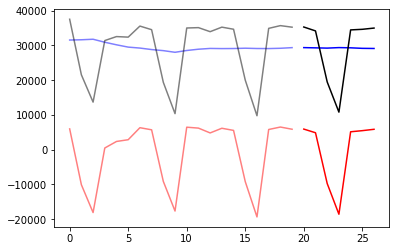

In [233]:
sample = 224

trend = m_time_scaler.inverse_transform(m_train_time[sample,:,-2], select_col = -2)
cycle = m_time_scaler.inverse_transform(m_train_time[sample,:,-1], select_col = -1)

plt.plot(np.arange(20),trend, color = "blue", alpha = 0.5)
plt.plot(np.arange(20),cycle, color = "red", alpha = 0.5)
plt.plot(np.arange(20),trend + cycle, color = "black", alpha = 0.5)

trend = m_time_scaler.inverse_transform(m_train_y[sample,:,0], select_col = -2)
cycle = m_time_scaler.inverse_transform(m_train_y[sample,:,1], select_col = -1)

plt.plot(np.arange(20,27),trend, color = "blue")
plt.plot(np.arange(20,27),cycle, color = "red")
plt.plot(np.arange(20,27),trend + cycle, color = "black")

plt.show()